# MRTS Project: ETL, Analysis, and Visualization

**Brian Kuo**

# Index

- [Abstract](#Abstract)
- [1. Introduction](#1.-Introduction)
- [2. Extract-Transform-Load](#2.-Extract-Transform-Load)
    - [2.1 The ETL Process](#2.1-The-ETL-Process)
    - [2.2 Data Exploration](#2.2-Data-Exploration)
    - [2.3 Data Preparation](#2.3-Data-Preparation)
    - [2.4 Read the Data Using Python and Saving to MySQL](#2.4-Reading-the-Data-Using-Python-and-Saving-to-MySQL)
         - [2.4.1 Reading the MRTS Data](#2.4.1-Reading-the-MRTS-Data)
         - [2.4.2 Saving to MySQL Workbench](#2.4.2-Saving-to-MySQL-Workbench)
    - [2.5 Writing an Installation Script](#2.5-Writing-an-Installation-Script)
- [3. Analysis and Visualization](#3.-Project-Description)
    - [3.1 Explore Trends](#3.1-Explore-Trends)
    - [3.2 Explore Percentage Change](#3.2-Explore-Percentage-Change)
    - [3.3 Explore Rolling Time Windows](#3.3-Explore-Rolling-Time-Windows)
- [Conclusion](#Conclusion)
- [References](#References)

[Back to top](#Index)


##  Abstract

This is a brief description (150 words or less) of your analysis and the results of your model. Complete this portion of the template after you are done working on your project.

This project is focused on analyzing the The Monthly Retail Trade Survey (MRTS) data provided by the US Census Bureau from 2018 to 2020. The data is implorted and cleaned before a closer look at several specific kinds of business sales is looked further into. Trends, Percentage change, and rolling time window techniques are implemented along with visualizations. 

Drill down of 

[Back to top](#Index)


## 1. Introduction

Introduce your project using 300 words or less. Describe all the processes you followed to create your ETL, Analysis, and Visualization project. Start by summarizing the steps that you intend to perform and then elaborate on this section after you have completed your project.

The objective of this project is to analyze the Monthly Retail Trade Survey (MRTS) data obtained from the US Census Bureau. The data is first imported and cleaned to ensure accuracy before conducting a detailed analysis of specific types of business sales. To achieve this, various techniques such as trend analysis, percentage change, and rolling time window are implemented. Visual aids are also utilized to facilitate a deeper understanding of the findings. By implementing these techniques, the project aims to provide a more comprehensive understanding of the MRTS data and its implications for retail businesses.

[Back to top](#Index)

## 2. Extract-Transform-Load

For each of the sections below, include a description of the steps you followed. Whenever possible, include screenshots of your code or program windows to demonstrate your steps.

[Back to top](#Index)

### 2.1 The ETL Process

Describe, using your own words, the key steps to perform ETL on the provided MRTS dataset.

1. Manually selected the unadjusted parts of the excel file be used in the project
2. CSV files were imported into MySQL workbench with data import Wizard
3. CSV files were read into the python script as data frames by year and joined together
4. Year month is pivoted to a single column for time series visualizations
5. Empty rows are removed as part of the pipeline

[Back to top](#Index)

### 2.2 Data Exploration

About the data:

* The MRTS dataset contains the sales data of different indestries in the past 10 years by month up until parts of 2021. It contains ajusted and none-adjusted data along with some notes in each excel tab.

[Back to top](#Index)

### 2.3 Data Preparation

* The main transformation on the data set is pivoting the date columns into a single column


[Back to top](#Index)

### 2.4 Read the Data Using Python and Saving to MySQL


The openpyxl module is implemented for reading in excel workbooks by sheet

In [80]:
# First importing some standard modules needed for the project
from datetime import datetime as dt
import pandas as pd
import numpy as np

[Back to top](#Index)

### 2.4.1 Reading the MRTS Data

MRTS excel file is read using a Python script, all the sheets stored as a table for easy access in MySQL

In [81]:
from openpyxl import load_workbook

# loading excel file
data_file = '/Users/bkuo/Local Documents/MIT xPro Data Enginneering/Module 8/mrtssales92-present.xlsx'

# Load the entire workbook with the load_workbook function
wb = load_workbook(data_file)

[Back to top](#Index)

### 2.4.2 Saving to MySQL Workbench

Setting up connection to MySQL with sqlalchemy module and saving the excel sheets into seperate data tables by saving each sheet into a data frame and writing to MySQL Workbench

In [82]:
# Filling in connection credentials
database_username = 'root'
database_password = 'Gtisveryc00l'
database_ip = 'localhost'
database_name = 'mrts'

In [83]:
import mysql.connector
import sqlalchemy

# Creating function to automate this part of the function
def to_db(sheet):
    # Load one worksheet.
    ws = wb[sheet]
    data = ws.values

    # Create DataFrames by selecting the appropriate data in each sheet
    df = pd.DataFrame(data)
    columns = list(df.iloc[4])
    columns = ['NAICS  Code', 'Kind of Business']+columns[2:]
    df.columns = columns
    df = df.iloc[6:71, :-2]

    # Making connection to MySQL with defined connection credentials
    database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                            format(database_username, database_password, 
                                                    database_ip, database_name))
    # Writing to MySQL db
    df.to_sql(con=database_connection, name='mrts'+sheet, if_exists='replace')


# All years except current year:
all_prev_years = wb.sheetnames[1:]
# Bringing all sheets into MySQL Workbench:
for sheet in all_prev_years:
    to_db(sheet)



[Back to top](#Index)

### 2.5 Writing an Installation Script

Describe how you wrote a Python installation script to read your dataset in MySQL WorkBench.

* The installation script allows the reading of the data from MySQL Workbench. 
* he following section of code pivoted the files to have dates the row. All years prior to the current year (2023) are combined into one:

In [ ]:
# Setting up connection credential to read from MySQL WorkBench
mydb = mysql.connector.connect(
    host = database_ip,
    user = database_username,
    password = database_password,
    database = database_name
)

# pivot reference: https://stackoverflow.com/questions/28654047/convert-columns-into-rows-with-pandas

appended_data = []

for year in all_prev_years:
    df = pd.read_sql('select * from mrts'+year, con = mydb)
    df = df.iloc[:,2:-1]
    pivot_df = df.melt(id_vars=["Kind of Business"], 
            var_name="Date", 
            value_name="Sales")
    appended_data.append(pivot_df)
mrts = pd.concat(appended_data)


Cleaning procedures on the format of the month and sales fields are included in the code below:

In [153]:
# Adjustments on Sales
mrts.loc[mrts['Sales'] == '(S)'] = np.nan
mrts.loc[mrts['Sales'] == '(NA)'] = np.nan
# mrts['Sales'] = mrts['Sales'].str.replace(',','')
mrts['Sales'] = pd.to_numeric(mrts['Sales'])

# Date conversion: https://stackoverflow.com/questions/65612231/convert-string-month-year-to-datetime-in-pandas-dataframe
mrts['Date'] = mrts['Date'].str.replace('.','') # 'May 2018' does not match format '%b. %Y' 
mrts['Date'] = pd.to_datetime(mrts['Date'], format='%b %Y')

# Resetting index:
mrts.reset_index(drop=True)

/var/folders/qt/81z4qyvx5bs3j01sh3nndrbw0000gn/T/ipykernel_38524/955527119.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mrts['Date'] = mrts['Date'].str.replace('.','') # 'May 2018' does not match format '%b. %Y'


,Kind of Business,Date,Sales
0,"Retail and food services sales, total",2022-01-01,587961.0
1,Retail sales and food services excl motor vehi...,2022-01-01,474414.0
2,Retail sales and food services excl gasoline s...,2022-01-01,538863.0
3,Retail sales and food services excl motor vehi...,2022-01-01,425316.0
4,"Retail sales, total",2022-01-01,518146.0
...,...,...,...
23525,Food services and drinking places,1992-12-01,17491.0
23526,Drinking places,1992-12-01,1034.0
23527,Restaurants and other eating places,1992-12-01,14994.0
23528,Full service restaurants,1992-12-01,7329.0


[Back to top](#Index)

## 3. Analysis and Visualization

[Back to top](#Index)

### 3.1 Explore Trends

What is an economic trend and why is it considered an important measure to predict quantities, like spending patterns?

* Economic trend indicates how a region or country is doing financially. In the case of MRTS data, different industries have its own trend and spending patterns. From analyzing and prediicting the quantitiy based on historical data, the industry or region of interest could develope strategies to better prepare for consumer demands. 

What is the trend of the retail and food services categories? Can this data be displayed clearly or do you need to adjust some parameters to reduce extraneous details and be able to visualize a clean trend?

* From plotting out monthly numbers, we could see a general trend of relatively low sales number in the beginig of the year and picks up throughout the year. 

In [155]:
# Looking at retail and food services:
retailAndfood = mrts[(mrts["Kind of Business"]=="Retail and food services sales, total")]
retailAndfood = retailAndfood[['Date', 'Sales']].reset_index(drop = True)
retailAndfood['Year'] = retailAndfood['Date'].dt.strftime('%Y')
retailAndfood = retailAndfood[['Year', 'Sales']].groupby('Year').sum()
retailAndfood.head()

,Sales
Year,
1992,2014102.0
1993,2153095.0
1994,2330235.0
1995,2450628.0
1996,2603794.0


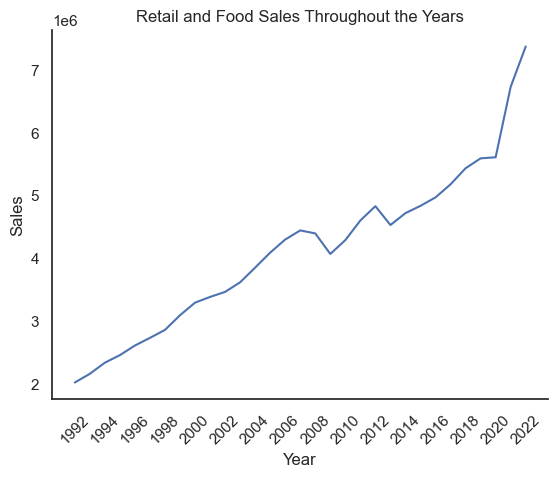

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

sns.set_theme(style="white")
chart = sns.lineplot(data=retailAndfood, x="Year", y="Sales")
sns.despine()
plt.xticks(rotation=45)
plt.title("Retail and Food Sales Throughout the Years")
myLocator = mticker.MultipleLocator(2)
chart.xaxis.set_major_locator(myLocator);


In [181]:
all_retail = mrts[ \
    (mrts["Kind of Business"]=="Motor vehicle and parts dealers") | \
    (mrts["Kind of Business"]=="Furniture and home furnishings stores") |
    (mrts["Kind of Business"]=="Electronics and appliance stores") |
    (mrts["Kind of Business"]=="Building mat. and garden equip. and supplies dealers") |
    (mrts["Kind of Business"]=="Food and beverage stores") |
    (mrts["Kind of Business"]=="Health and personal care stores") |
    (mrts["Kind of Business"]=="Gasoline stations") |
    (mrts["Kind of Business"]=="Clothing and clothing access. stores") |
    (mrts["Kind of Business"]=="Sporting goods, hobby, musical instrument, and book stores") |
    (mrts["Kind of Business"]=="General merchandise stores") |
    (mrts["Kind of Business"]=="Miscellaneous store retailers") |
    (mrts["Kind of Business"]=="Nonstore retailers") 
]

all_retail = all_retail[['Date', 'Sales','Kind of Business']].reset_index(drop = True)
all_retail['Year'] = all_retail['Date'].dt.strftime('%Y')
all_retail = all_retail.groupby(['Year', 'Kind of Business']).sum()
all_retail.head()


Sales
Year Kind of Business                                            
1992 Building mat. and garden equip. and supplies de...  130989.0
     Clothing and clothing access. stores                120103.0
     Electronics and appliance stores                     48691.0
     Food and beverage stores                            370513.0
     Furniture and home furnishings stores                52336.0

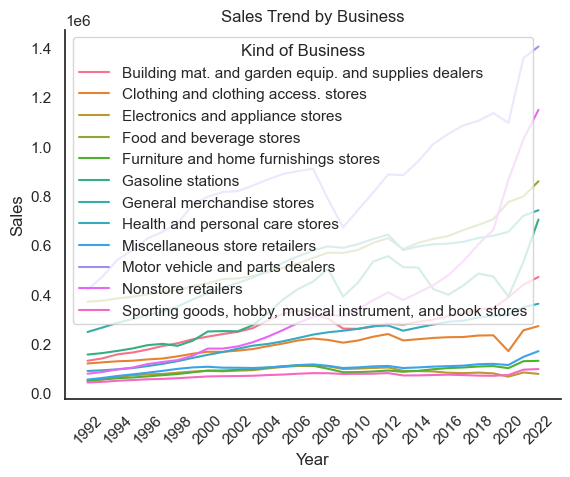

In [223]:
sns.set_theme(style="white")
chart = sns.lineplot(data=all_retail, x="Year", y="Sales", hue="Kind of Business")
sns.despine()
plt.xticks(rotation=45)
plt.title("Sales Trend by Business")
myLocator = mticker.MultipleLocator(2)
chart.xaxis.set_major_locator(myLocator);

When comparing businesses like bookstores, sporting goods stores, and hobbies, toys, and games stores, what is the highest trend of all of these options? Which one grew faster? Which one is higher? Is there a seasonal pattern? Were there any changes in 2020? Which is better, monthly or yearly? 

From the plot generated by the following code cells:
* Sporting goods stores has the highest trend from 2018 to 2020 overall
* Sporting goods stores grew the fastest and reached the highest sales
* Besides book stores, the other two category has seasonality, with end of year being their peak times
* There is an unusual dip in sales number for all categories in about March of 2020 that could be further researched, but it is potentially caused by the happening of COVID-19. However, the general trend is still the same with the end of year being the categories' peak
* There is no significant advantage between monthly and yearly plots. Monthly analysis allows for more detailed plotting, but may be too noisy if there are many years; yearly is great for exploring multi-year trends since it smoothes out the noise of the monthly data; however yearly data misses out on the abiility to analize seaonal trends. Hence, a thorough exploration of a data set would be examining both

In [210]:
# Looking at the following three categories:
compare = mrts[ \
    (mrts["Kind of Business"]=="Clothing stores") | \
    (mrts["Kind of Business"]=="Men's clothing stores") | \
    (mrts["Kind of Business"]=="Women's clothing stores") | \
    (mrts["Kind of Business"]=="Family clothing stores") | \
    (mrts["Kind of Business"]=="Other clothing stores")     
]
compare = compare.reset_index(drop = True)
compare.head()

,Kind of Business,Date,Sales
0,Clothing stores,2022-01-01,12368.0
1,Women's clothing stores,2022-01-01,2422.0
2,Family clothing stores,2022-01-01,6734.0
3,Other clothing stores,2022-01-01,1277.0
4,Clothing stores,2022-02-01,13204.0


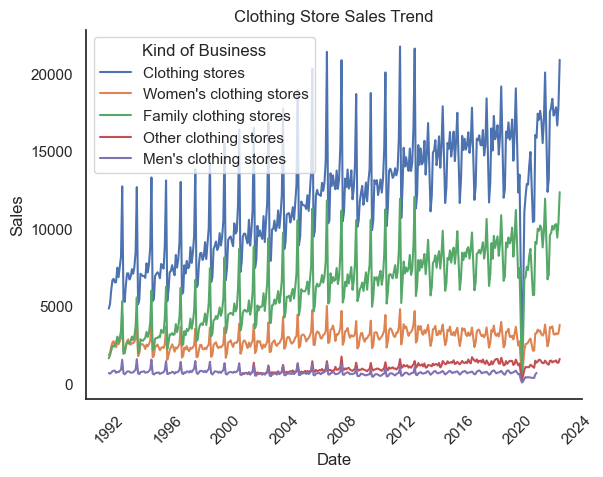

In [224]:
sns.set_theme(style="white")
chart = sns.lineplot(data=compare, x="Date", y="Sales", hue="Kind of Business")
sns.despine()
plt.title("Clothing Store Sales Trend")
plt.xticks(rotation=45);

[Back to top](#Index)

### 3.2 Explore Percentage Change

Describe which *queries* you wrote to explore the differences in trends between various categories in your data.

In your submission make sure to answer the following:

In economics, what is the percentage change and why is it considered an important measure to predict quantities like spending patterns?
  - the percentage change is a measure of the percentage difference between two values. It is calculated by dividing the difference between the two values by the original value, and then multiplying the result by 100


  - It could be used to calculate the degree of change in consumer spending among months or years and from that we could know the year to year or month to month comparison of how consumers spend. Different groups of consumers could also be compared and stragegies could be made for businesses according to the result of the analysis
  

Consider the women's clothing and men's clothing businesses and their percentage change. How are these two businesses related? For each of the two businesses, what is the percentage of contribution to the whole and how does it change over time?
* Wemon clothing sales has a similar trend and seasonality as men clothing sales, but the degree of sale is a lot higher for women
* Of all clothing sale contributions are **less than 1% of overall** (all business categories) sales
* pre-COVID time (before beginning of 2020): men falls roughly between 18%-20% of all clothing sales, which puts women clothing sales at 78%-80% of sales
* post-COVID: men's clothing sales fell to almost 12% of all sales, but has been gradually climbing back to around 15% by the end of 2020. This puts women clothing sales at 85%-88% of clothing sales

In [218]:
# Looking at the following clothing sales among men and women:
clothing = mrts[ \
    (mrts["Kind of Business"]=="Clothing stores") | \
    (mrts["Kind of Business"]=="Women's clothing stores") | \
    (mrts["Kind of Business"]=="Men's clothing stores")
]
clothing = clothing.reset_index(drop = True)
clothing_piv = clothing.pivot_table(columns = 'Kind of Business', values='Sales', index='Date')
clothing_piv['lagged_sales_men'] = clothing_piv["Men's clothing stores"].shift(1)
clothing_piv['lagged_sales_women'] = clothing_piv["Women's clothing stores"].shift(1)
clothing_piv['pct_change_men'] = (clothing_piv["Men's clothing stores"]-clothing_piv["lagged_sales_men"])/clothing_piv["lagged_sales_men"]
clothing_piv['pct_change_women'] = (clothing_piv["Women's clothing stores"]-clothing_piv["lagged_sales_women"])/clothing_piv["lagged_sales_women"]

clothing_piv['pct_sales_men'] = 100*clothing_piv["Men's clothing stores"]/(clothing_piv["Clothing stores"])
clothing_piv['pct_sales_women'] = 100*clothing_piv["Women's clothing stores"]/(clothing_piv["Clothing stores"])

clothing_piv.head()

Kind of Business,Clothing stores,Men's clothing stores,Women's clothing stores,lagged_sales_men,lagged_sales_women,pct_change_men,pct_change_women,pct_sales_men,pct_sales_women
Date,,,,,,,,,
1992-01-01,4852.0,701.0,1873.0,NaN,NaN,NaN,NaN,14.447650,38.602638
1992-02-01,5159.0,658.0,1991.0,701.0,1873.0,-0.061341,0.063001,12.754410,38.592751
1992-03-01,6024.0,731.0,2403.0,658.0,1991.0,0.110942,0.206931,12.134794,39.890438
1992-04-01,6682.0,816.0,2665.0,731.0,2403.0,0.116279,0.109030,12.211913,39.883268
1992-05-01,6768.0,856.0,2752.0,816.0,2665.0,0.049020,0.032645,12.647754,40.661939


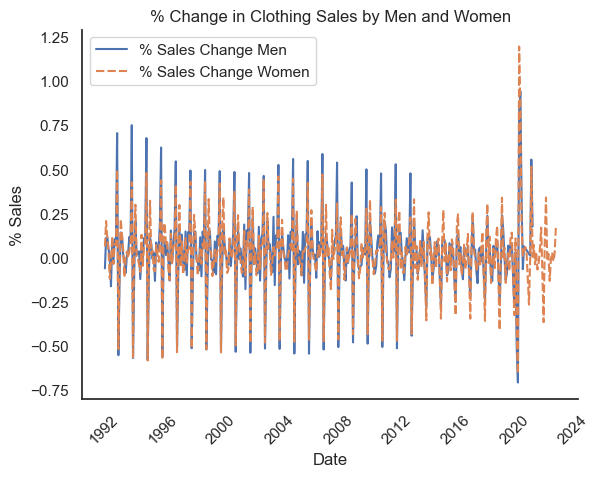

In [225]:
# Percent Change of men and women clothing sales
sns.set_theme(style="white")
chart = sns.lineplot(data=clothing_piv[['pct_change_men', 'pct_change_women']])
plt.ylabel('% Sales')
plt.legend(labels = ['% Sales Change Men', '% Sales Change Women'])
plt.title("% Change in Clothing Sales by Men and Women")
sns.despine()
plt.xticks(rotation=45);

In [186]:
# Overall sales by month
total_sale = mrts[(mrts["Kind of Business"]=="Retail and food services sales, total")]\
    .groupby(['Date']).sum().reset_index()

total_sale.rename(columns={'Sales':'total_sales'}, inplace = True)

# Overall sales by month for men and women
men = mrts[(mrts["Kind of Business"]=="Men's clothing stores")].iloc[:,[1,2]].reset_index(drop = True)
men.rename(columns={'Sales':'men_clothing_sales'}, inplace = True)

women = mrts[(mrts["Kind of Business"]=="Women's clothing stores")].iloc[:,[1,2]].reset_index(drop = True)
women.rename(columns={'Sales':'women_clothing_sales'}, inplace = True)

# Combine data
df = pd.merge(total_sale, men, how = 'left', on = ['Date'])
pct = pd.merge(df, women, how = 'left', on = ['Date'])
pct['pct_men'] = pct['men_clothing_sales']/pct['total_sales']*100
pct['pct_women'] = pct['women_clothing_sales']/pct['total_sales']*100
pct.set_index(keys = 'Date', inplace = True, drop = True)
pct.head()


,total_sales,men_clothing_sales,women_clothing_sales,pct_men,pct_women
Date,,,,,
1992-01-01,146376.0,701.0,1873.0,0.478904,1.279581
1992-02-01,147079.0,658.0,1991.0,0.447379,1.353694
1992-03-01,159336.0,731.0,2403.0,0.458779,1.508134
1992-04-01,163669.0,816.0,2665.0,0.498567,1.628286
1992-05-01,170068.0,856.0,2752.0,0.503328,1.618176


In [227]:
# Overall percentage of men and women clothing sales contribute to all sales:
overall_men = pct['men_clothing_sales'].sum()/pct['total_sales'].sum()*100
overall_women = pct['women_clothing_sales'].sum()/pct['total_sales'].sum()*100

print("Overall men and women clothing sales are {}% and {}% of all retail and food sale respectively since 1992" \
      .format(overall_men, overall_women))

Overall men and women clothing sales are 0.1958018295834817% and 0.8241420497656132% of all retail and food sale respectively since 1992


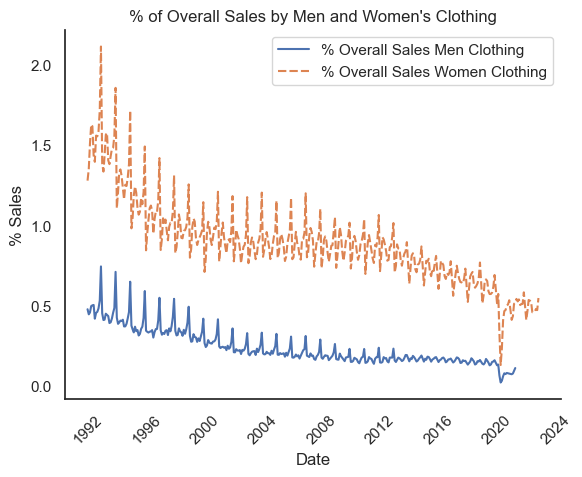

In [229]:
# Visualizing overall contribution of men and women clothing sales
sns.set_theme(style="white")
chart = sns.lineplot(data=pct[['pct_men', 'pct_women']])
plt.ylabel('% Sales')
plt.legend(labels = ['% Overall Sales Men Clothing', '% Overall Sales Women Clothing'])
plt.title("% of Overall Sales by Men and Women's Clothing")
sns.despine()
plt.xticks(rotation=45);

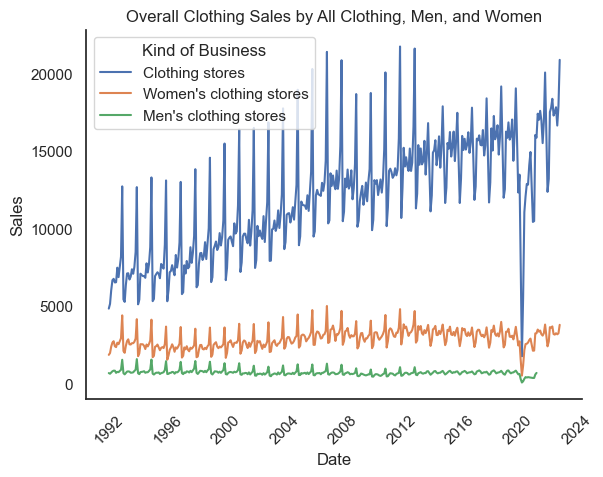

In [232]:
# Overall sales trends for men and women clothing stores
sns.set_theme(style="white")
chart = sns.lineplot(data=clothing, x="Date", y="Sales", hue="Kind of Business")
plt.title("Overall Clothing Sales by All Clothing, Men, and Women")
sns.despine()
plt.xticks(rotation=45);

[Back to top](#Index)

### 3.3 Explore Rolling Time Windows


Exploring trends with rolling time window for the clothing and clothing accessory store business category:
- Utilized the rolling() function to create rolling window of 3 months average sales. Combined the actual sales data for comparison in line graph


- Utilized the resample() function to aggregate data to quarterly data. Similar 3 months rolling average sales is pulled in for comparison in side to side bar charts

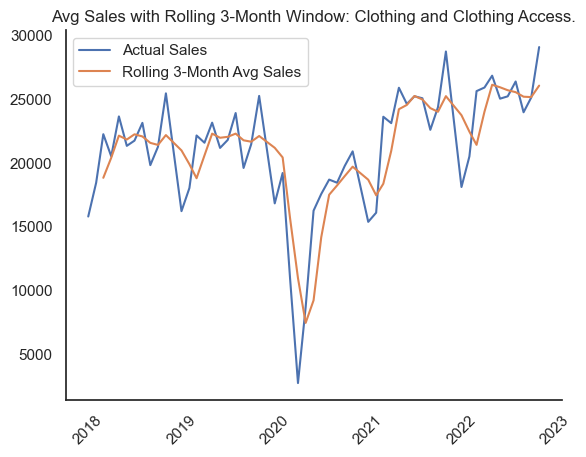

In [233]:
# Clothing and clothing access. stores
food = mrts[(mrts['Kind of Business'] == 'Clothing and clothing access. stores') \
    & (mrts['Date'] >= '2018-1-1')\
    ][['Date', 'Sales']]
food.set_index('Date', inplace=True)
food.sort_index(ascending=True, inplace=True)
food['Sales'] = pd.to_numeric(food['Sales'])
food['Rolling 3-Month Sales'] = food['Sales'].rolling(window=3).mean()

sns.set_theme(style="white")

# plot the original sales data
plt.plot(food['Sales'], label='Actual Sales')

# plot the sales data with rolling 3-month window
plt.plot(food['Rolling 3-Month Sales'], label='Rolling 3-Month Avg Sales')
plt.title('Avg Sales with Rolling 3-Month Window: Clothing and Clothing Access.')
plt.legend()

sns.despine()
plt.xticks(rotation=45);


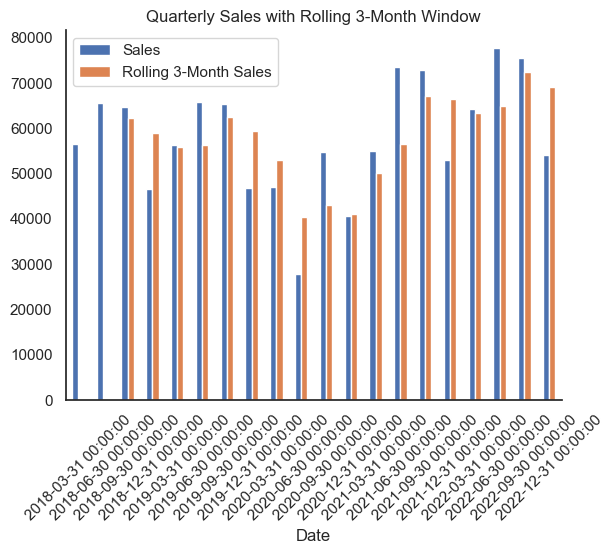

In [217]:
# 'Clothing and clothing access. stores' sales in bar chart
disc = mrts[(mrts['Kind of Business'] == 'Clothing and clothing access. stores') \
    & (mrts['Date'] >= '2018-1-1')][['Date', 'Sales']]
disc.set_index('Date', inplace=True)

# resample the sales data by quarter
quarterly_sales = disc.resample('Q').sum()

# calculate rolling 3-month window sales for each quarter
quarterly_sales['Rolling 3-Month Sales'] = quarterly_sales['Sales'].rolling(window=3).mean()

ax = quarterly_sales.plot(kind='bar', y=['Sales', 'Rolling 3-Month Sales'])

# set the plot title and legend
ax.set_title('Quarterly Sales with Rolling 3-Month Window')
ax.legend()

sns.despine()
plt.xticks(rotation=45);

[Back to top](#Index)

## Conclusion 


From the following cell, we can see the "Motor vehicle and parts dealers" attracts the most spending, whereas the "Sporting goods, hobby, musical instrument, and book stores" businesses attact the least spending from 1992 to 2022.

In [234]:
# all business retail categories (no sub categories included):
# all_retail defined in previous cells

max_min_spend = all_retail.groupby(['Kind of Business']).sum().reset_index()
max_min_spend.sort_values(by = ['Sales'],ascending = False)


,Kind of Business,Sales
9,Motor vehicle and parts dealers,26550022.0
3,Food and beverage stores,16987955.0
6,General merchandise stores,15816683.0
5,Gasoline stations,11366109.0
10,Nonstore retailers,11026221.0
0,Building mat. and garden equip. and supplies d...,8491083.0
7,Health and personal care stores,6776498.0
1,Clothing and clothing access. stores,5978224.0
8,Miscellaneous store retailers,3229108.0
4,Furniture and home furnishings stores,2849799.0



[Back to top](#Index
)
## References

Add all references you used to complete this project.

Use this format for articles:
- Author Last Name, Author First Name. “Article Title.” Journal Title Volume #, no. Issue # (year): page range.

- Ex: Doe, John. “Data Engineering.” Data Engineering Journal 18, no. 4 (2021): 12-18.

Use this format for websites:
- Author Last Name, Author First Name. “Title of Web Page.” Name of Website. Publishing organization, publication or revision date if available. Access date if no other date is available. URL .

- Doe, John. “Data Engineering.” Data Engineer Resource. Cengage, 2021. www.dataengineerresource.com .

- https://ehmatthes.github.io/pcc_2e/beyond_pcc/extracting_from_excel/
- https://www.soudegesu.com/en/post/python/pandas-with-openpyxl/

- https://stackoverflow.com/questions/16476413/how-to-insert-pandas-dataframe-via-mysqldb-into-database
- https://planetscale.com/blog/using-mysql-with-sql-alchemy-hands-on-examples
- https://www.census.gov/retail/mrts_general_faqs.html
